In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [2]:
import optimizor

#from optimizor import eta_2_Gamma
#from optimizor import Gamma_2_eta
#from optimizor import logdotexp

from optimizor import delta_2_eta0
from optimizor import Gamma_2_eta
from optimizor import eta0_2_delta
from optimizor import eta_2_Gamma
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

In [16]:
K = [5,1]
methods = ["BFGS","SAGA","SVRG","GD","CG"]
d = 1
T = 1000
partial_Es = [0,0.5,1]

tol = 1e-3

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

#"experiment_1_2022-08-05_20-27-39"
#"experiment_1_2022-08-05_20-26-58"
#"experiment_1_2022-08-05_20-26-22"
#"experiment_1_2022-08-05_20-25-49"
#"experiment_1_2022-08-05_20-25-36"
#"experiment_1_2022-08-05_20-27-53"
#"experiment_1_2022-08-05_20-25-18"
#"experiment_1_2022-08-05_20-25-12"

#with open("../params/experiment_1_2022-08-05_20-25-49","rb") as f:
#    optims = pickle.load(f)
    
fname = "../params/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d" % (T,K[0],K[1],d,"control",0,0.0)
with open(fname,'rb') as f:
    print(fname)
    optims["control"] = pickle.load(f)

for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD"] and partial_E > 0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            best_fname = "../params/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d" % (T,K[0],K[1],d,method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(1):
                
                fname = "../params/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d" % (T,K[0],K[1],d,method,partial_E,rand_seed)
                
                with open(fname, 'rb') as f:
                    optim = pickle.load(f)
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)

../params/T-1000_K-5-1_d-1_control_0.0_000
../params/T-1000_K-5-1_d-1_BFGS_0.0_000
../params/T-1000_K-5-1_d-1_SAGA_0.0_000
../params/T-1000_K-5-1_d-1_SAGA_0.5_000
../params/T-1000_K-5-1_d-1_SAGA_1.0_000
../params/T-1000_K-5-1_d-1_SVRG_0.0_000
../params/T-1000_K-5-1_d-1_SVRG_0.5_000
../params/T-1000_K-5-1_d-1_SVRG_1.0_000
../params/T-1000_K-5-1_d-1_GD_0.0_000
../params/T-1000_K-5-1_d-1_CG_0.0_000


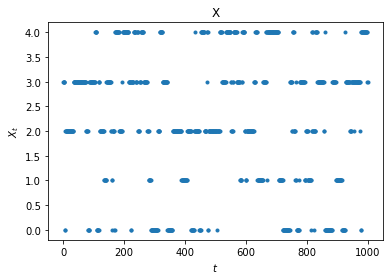

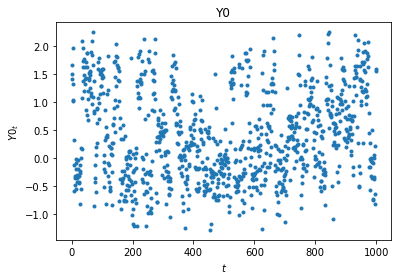

In [17]:
# plot hidden states
with open("../dat/data_X_T-%d_K-%d-%d_d-%d" % (T,K[0],K[1],d),"rb") as f:
    data_x = pickle.load(f)
plt.plot([x for x in data_x],'.')  
plt.xlabel(r"$t$")
plt.ylabel(r"$X_t$")
plt.title("X")
plt.show()

# plot data
with open("../dat/data_Y_T-%d_K-%d-%d_d-%d" % (T,K[0],K[1],d),"rb") as f:
    data_y = pickle.load(f)    
for key in data_y[0]:
    plt.plot([x[key] for x in data_y],'.')
    plt.xlabel(r"$t$")
    plt.ylabel(r"$%s_t$"%key)
    plt.title(key)
    plt.show()

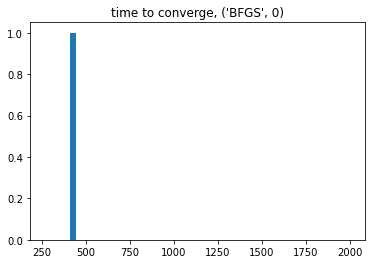

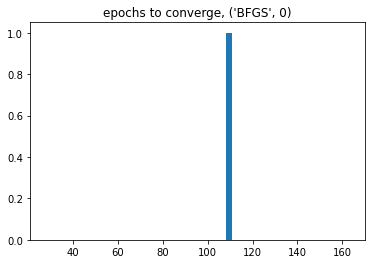

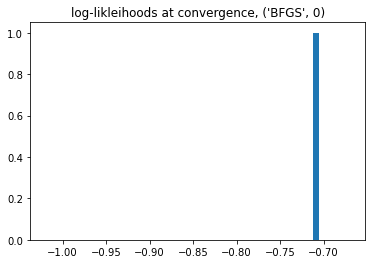

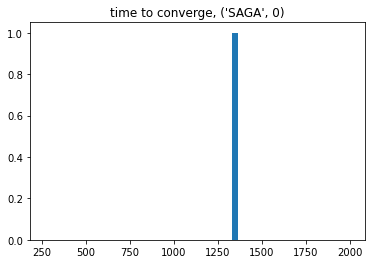

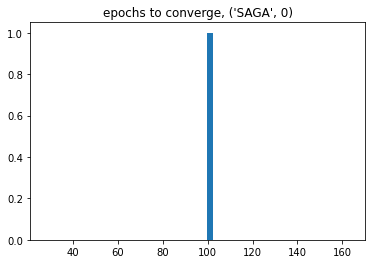

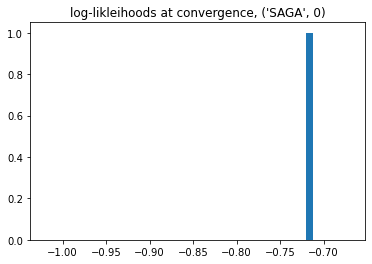

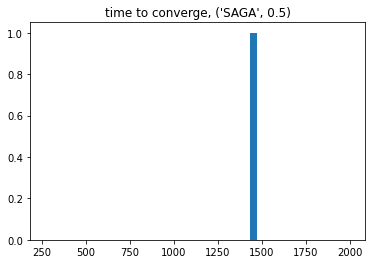

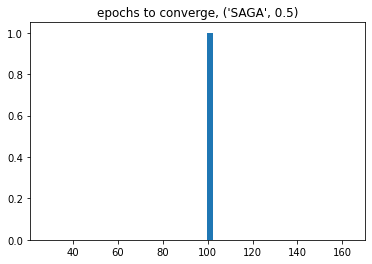

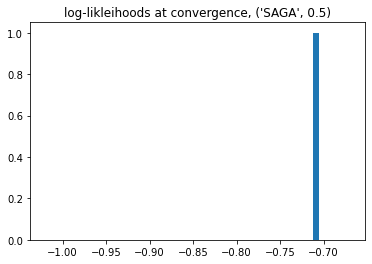

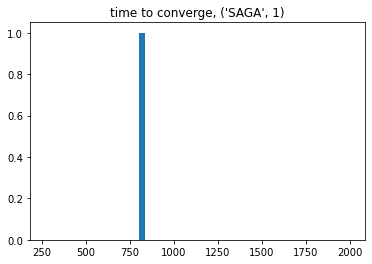

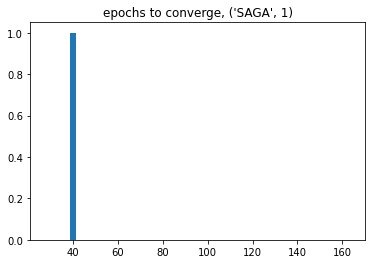

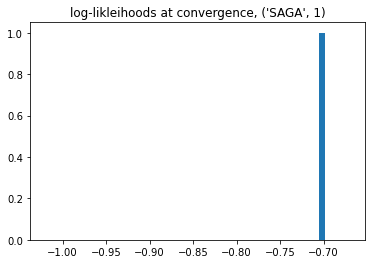

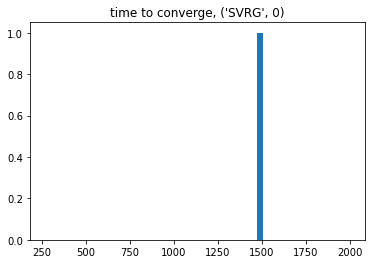

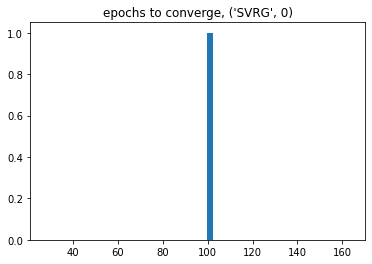

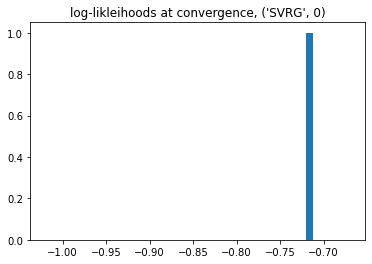

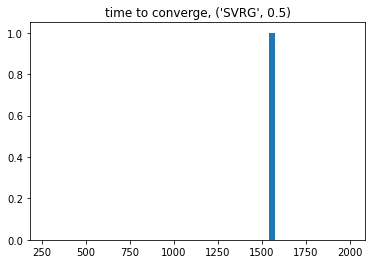

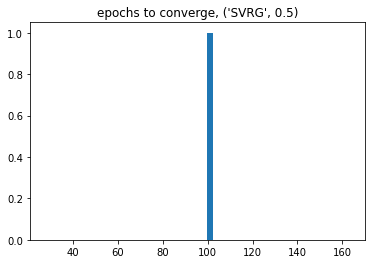

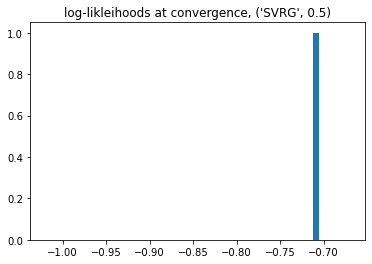

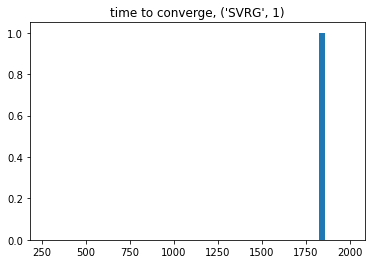

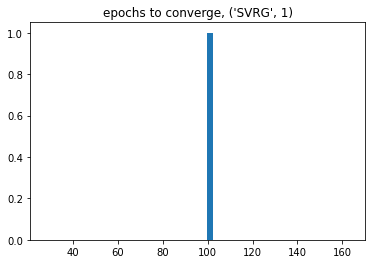

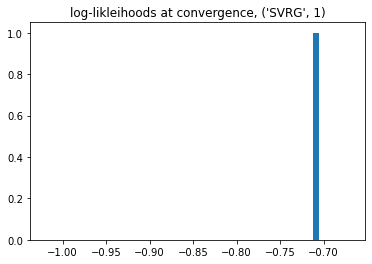

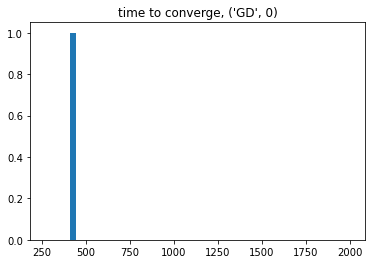

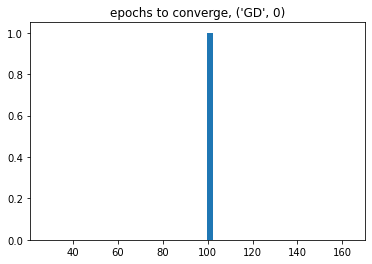

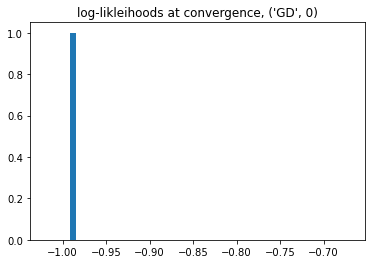

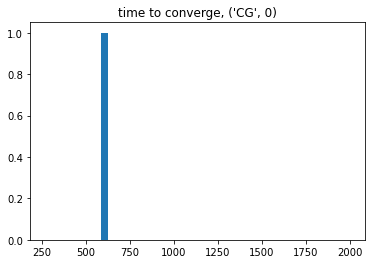

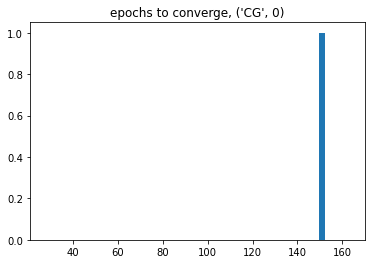

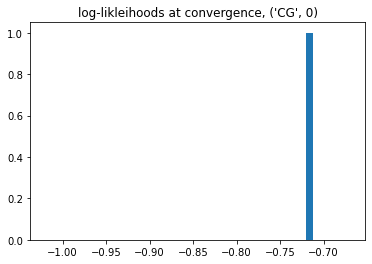

In [18]:
# get min and max time
def get_bins(dictionary,nbins):
    mini = np.infty
    maxi = -np.infty
    for key,values in dictionary.items():
        if mini > min(values):
            mini = min(values)
        if maxi < max(values):
            maxi = max(values)
    return np.linspace(mini - 0.1*(maxi-mini),maxi + 0.1*(maxi-mini),nbins)

        
for key in optims:
    
    if key == "control":
        continue
        
    plt.hist(times_to_converge[key],
             bins=get_bins(times_to_converge,50))
    plt.title("time to converge, %s" % str(key))
    plt.show()
    
    plt.hist(epochs_to_converge[key],
             bins=get_bins(epochs_to_converge,50))
    plt.title("epochs to converge, %s" % str(key))
    plt.show()
    
    plt.hist(lls[key],
             bins=get_bins(lls,50))
    plt.title("log-likleihoods at convergence, %s" % str(key))
    plt.show()

# Plot Results

In [19]:
methods = ["BFGS","SAGA","SVRG","CG","GD"]

ll_star = optims["control"].log_like_trace[-1]
method_star = "control"
for key in optims:
    if ll_star < optims[key].log_like_trace[-1]:
        print("control model has lower likelihood than test model")
        ll_star = optims[key].log_like_trace[-1]
        method_star = key
optims["control"].features[1]
        
true_mus = [{'Y'      : np.array([1.0,1.0,2.0,2.0]),
             'Y_star' : np.array([1.0,2.0,1.0,2.0])},
            
            {'Y' : np.array([1.0,2.0,3.0])},
           
            {'Y' : np.array([ 0.40015721, 0.97873798, 2.2408932 , 1.86755799, -0.97727788])}]

true_sigs = [{'Y'      : np.array([-1.0,-1.0,-1.0]),
              'Y_star' : np.array([-1.0,-1.0,-1.0])},
            
            {'Y' : np.array([-1.0,-1.0,-1.0])},
           
            {'Y' : np.array([-1.0,-1.0,-1.0,-1.0,-1.0])}]

def plot_ll(optims,x_time=False):
    
    legend = []
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    plt.title(ll_star)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_T-%d_K-%d-%d_d-%d" % (T,K[0],K[1],d),dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_T-%d_K-%d-%d_d-%d" % (T,K[0],K[1],d),dpi=500)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,features,T,K,d,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),dpi=500)
    plt.show()

    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))
                
        # plot true means
        #for mu in true_mus[experiment-1][feature]:
        #    plt.axhline(mu, c = 'k', linestyle = "--")

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/mu-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),dpi=500)
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))
        
        # plot true log(sigmas)
        #for log_sig in true_sigs[experiment-1][feature]:
        #    plt.axhline(log_sig, c = 'k', linestyle = "--")

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/log-sig-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),dpi=500)
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),dpi=500)
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-fine-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()
    
    return

control model has lower likelihood than test model


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_21909/3028800370.py:41: RuntimeWarning: divide by zero encountered in log10
  plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))


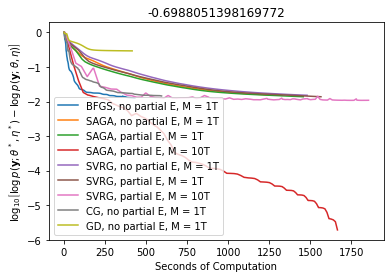

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_21909/3028800370.py:43: RuntimeWarning: divide by zero encountered in log10
  plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))


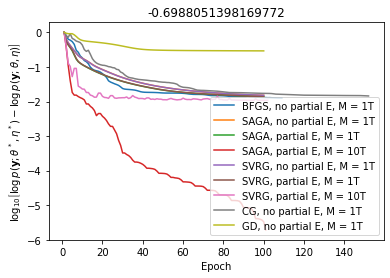

In [20]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

In [15]:
method_star

'control'

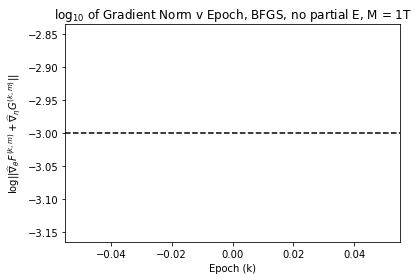

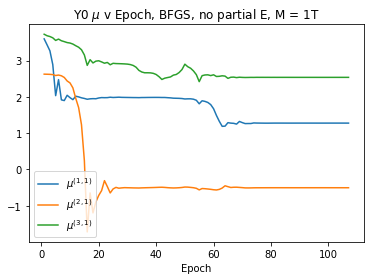

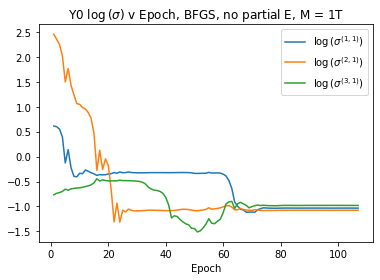

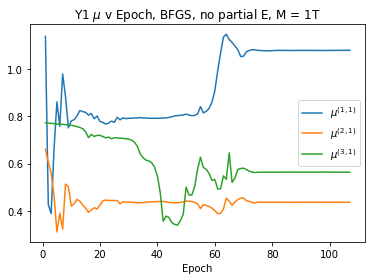

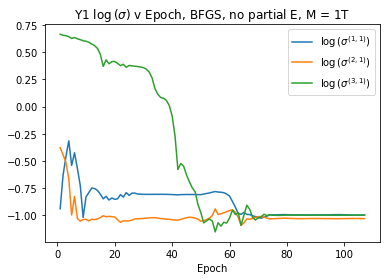

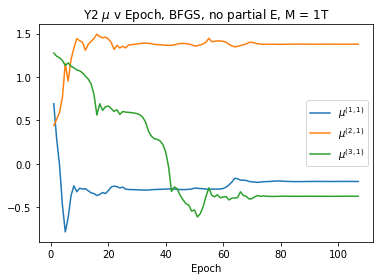

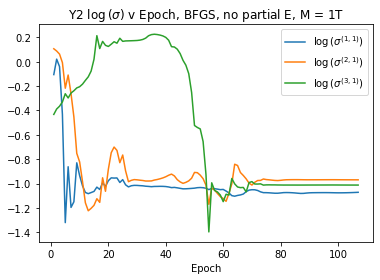

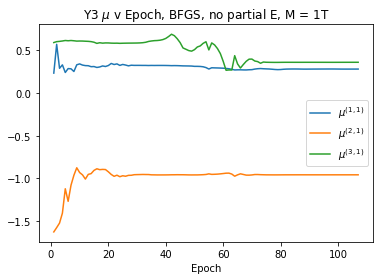

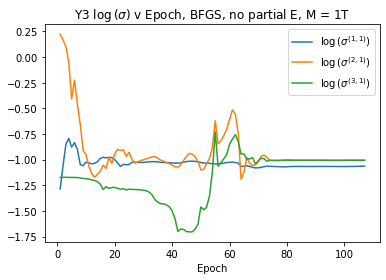

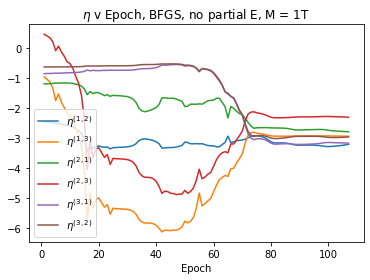

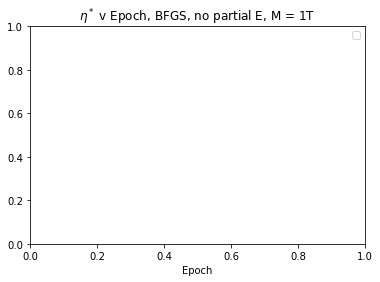

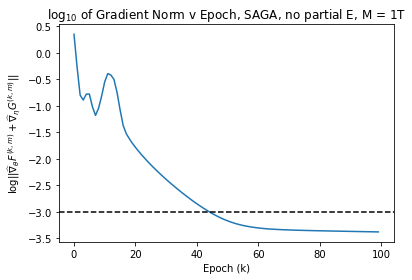

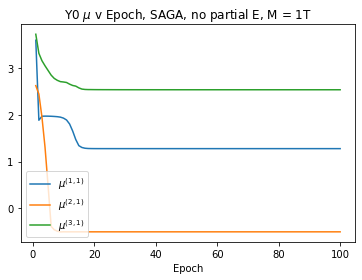

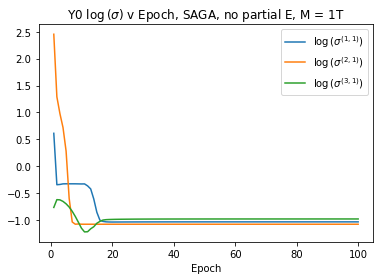

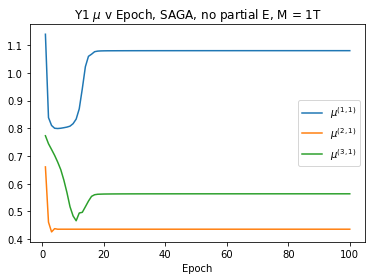

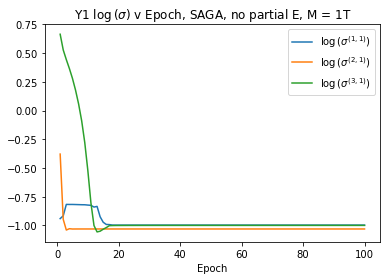

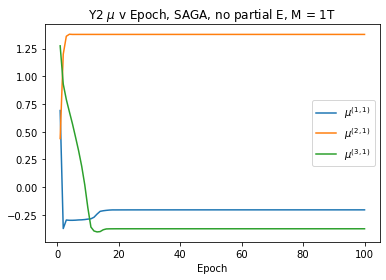

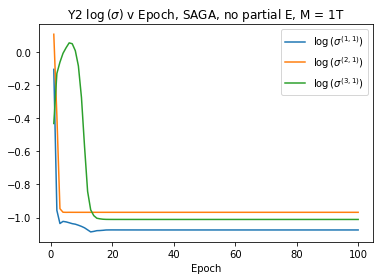

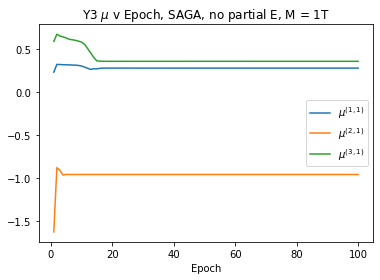

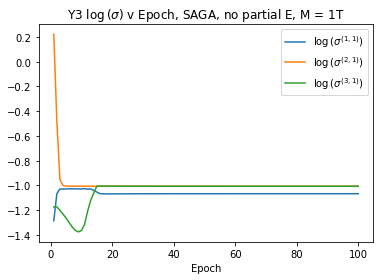

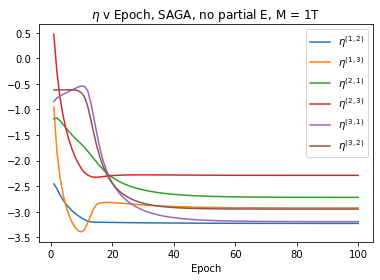

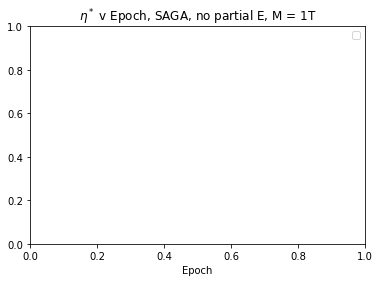

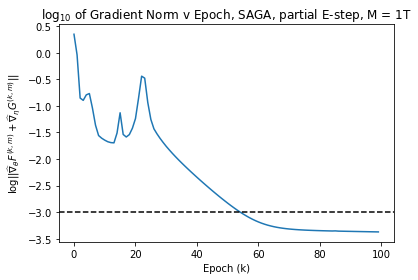

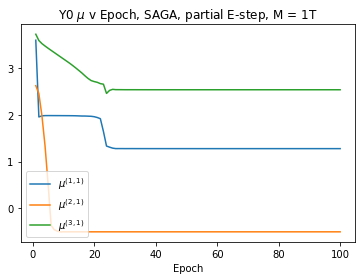

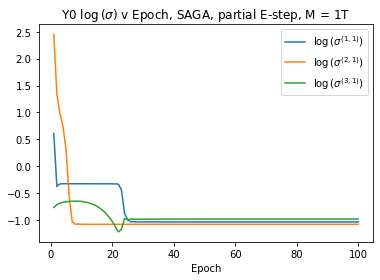

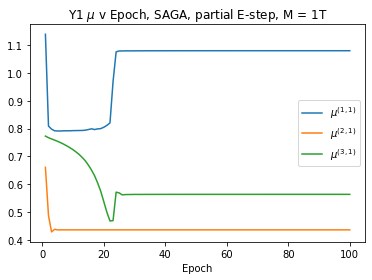

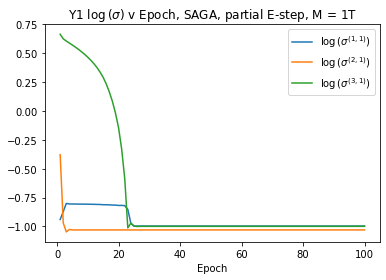

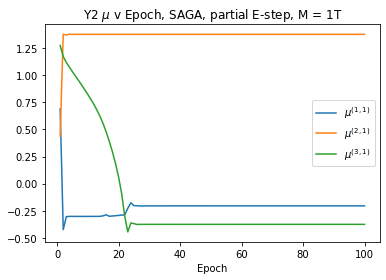

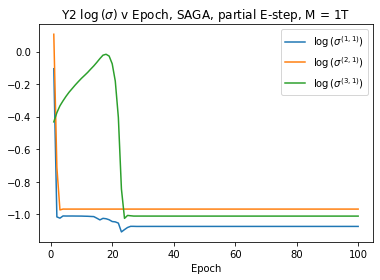

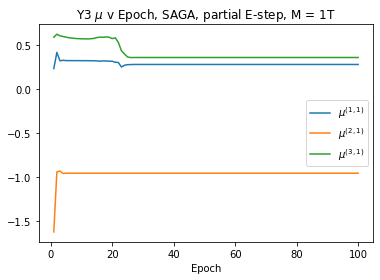

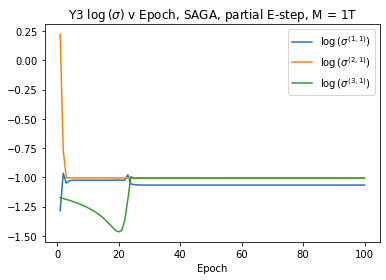

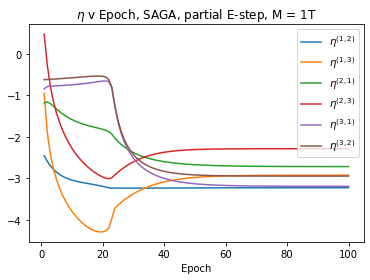

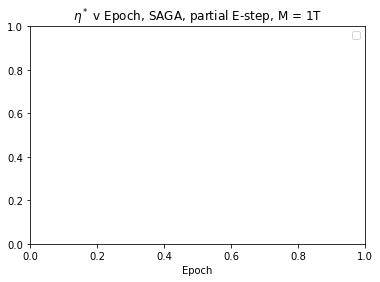

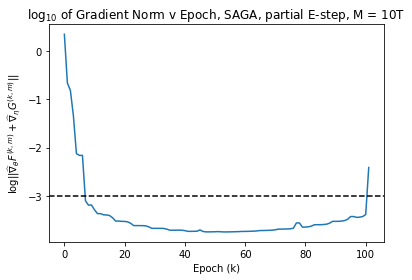

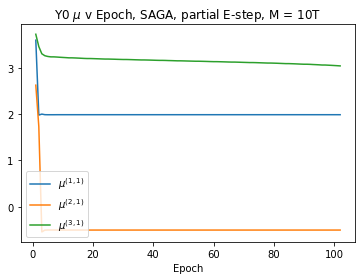

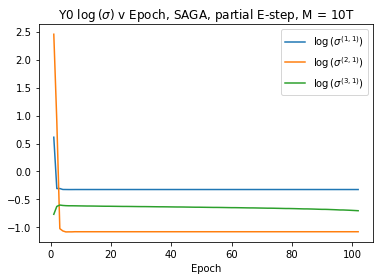

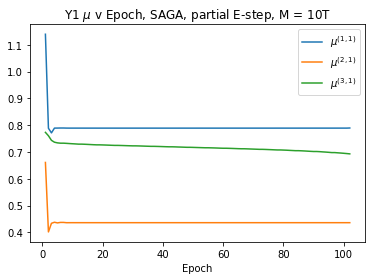

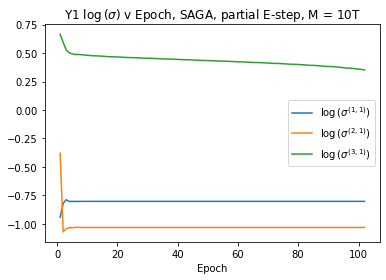

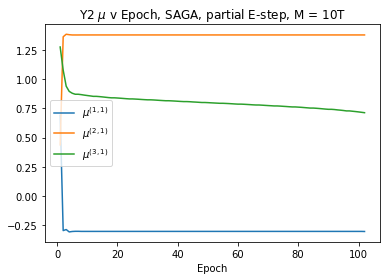

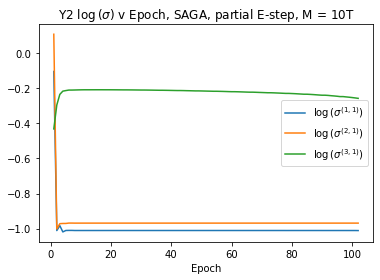

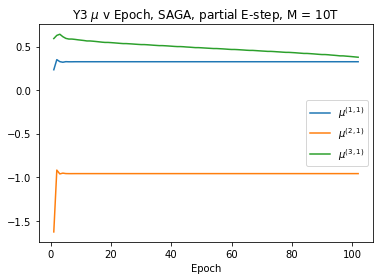

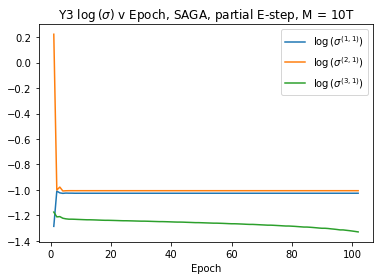

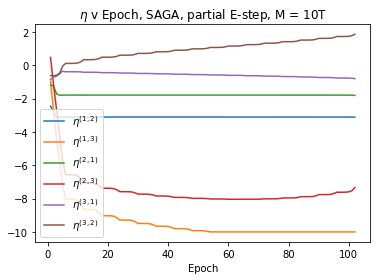

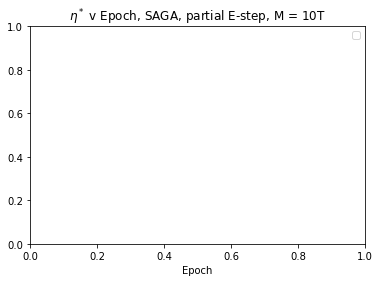

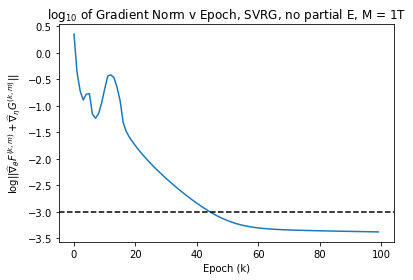

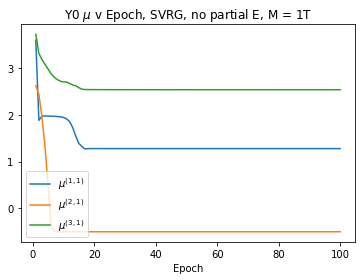

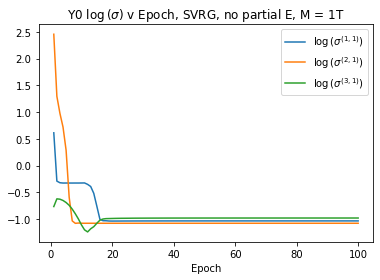

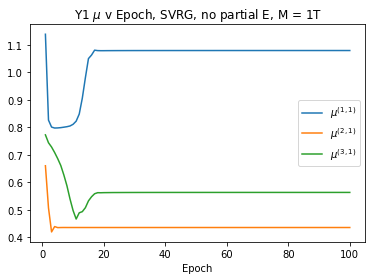

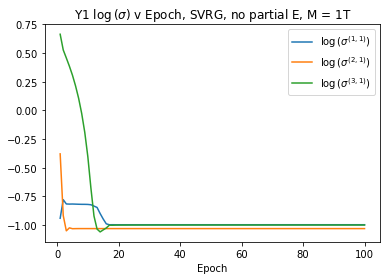

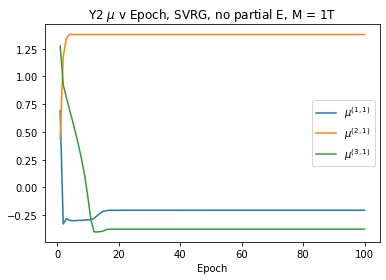

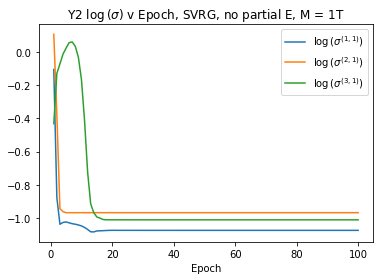

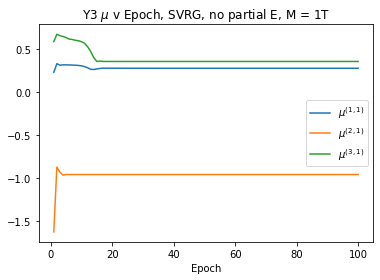

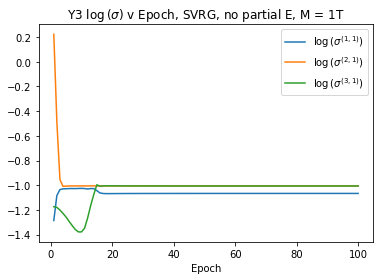

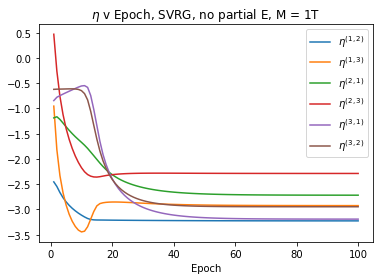

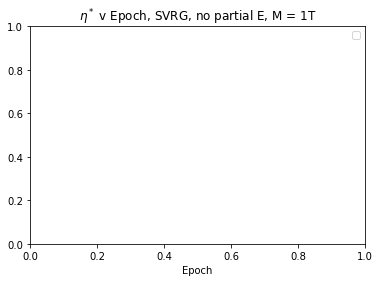

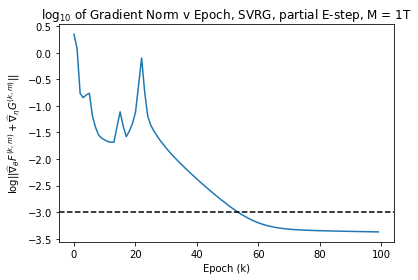

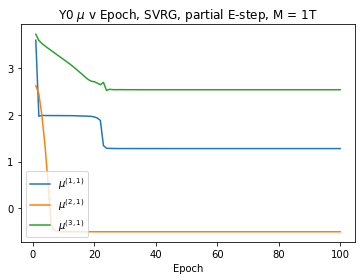

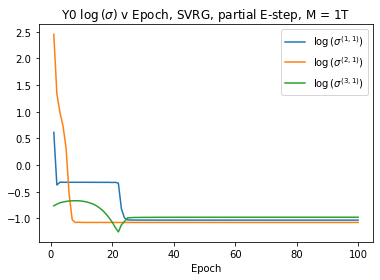

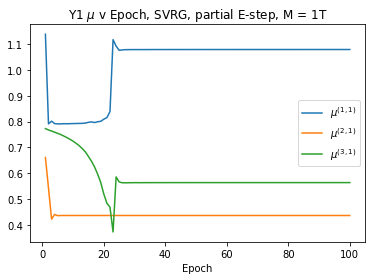

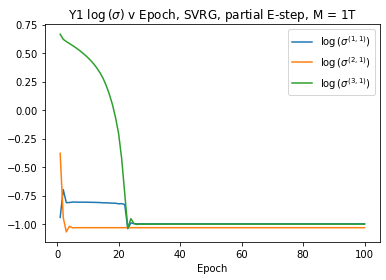

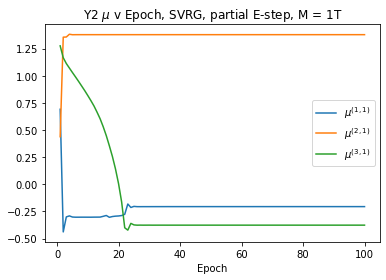

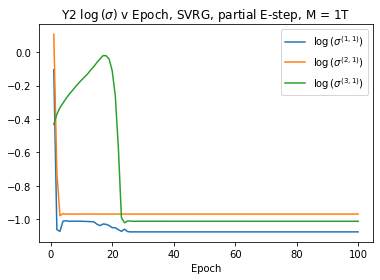

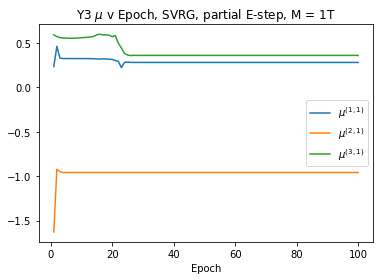

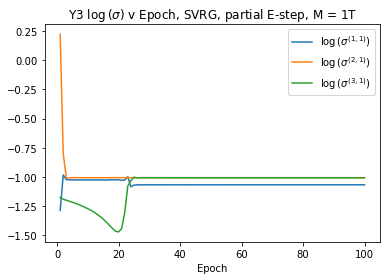

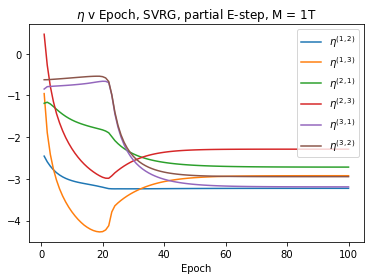

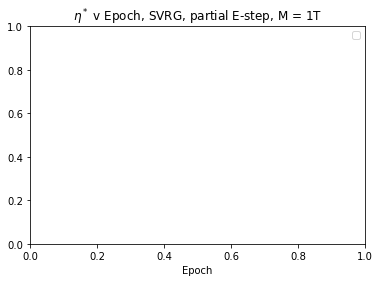

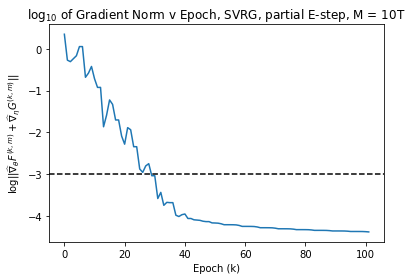

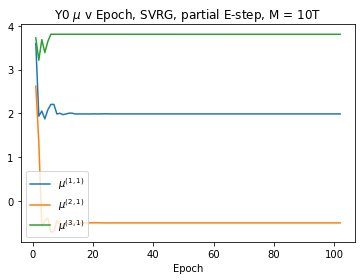

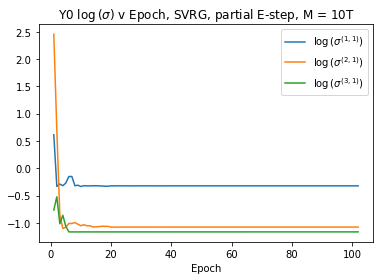

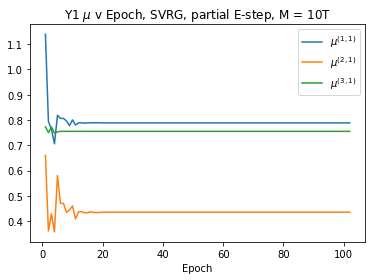

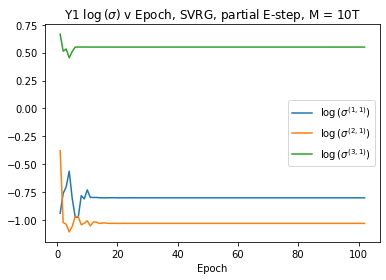

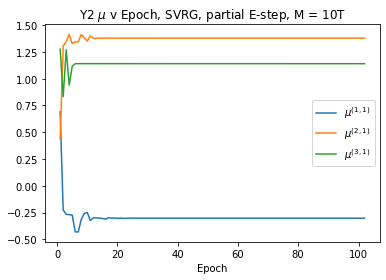

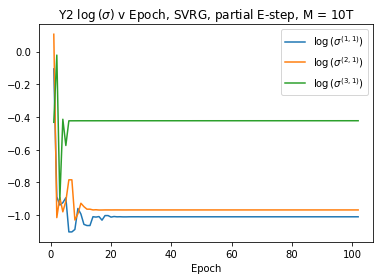

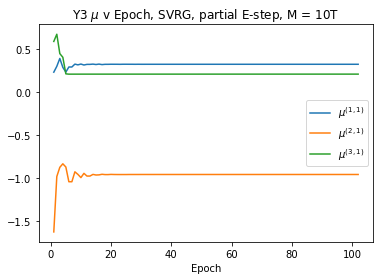

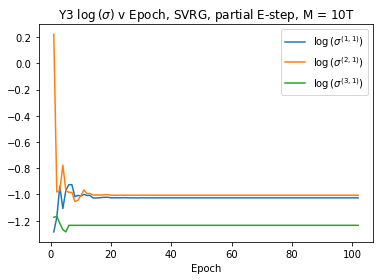

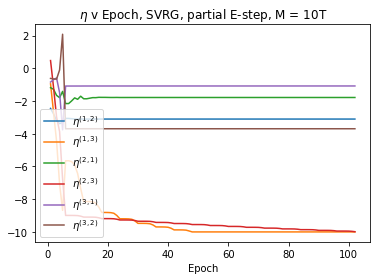

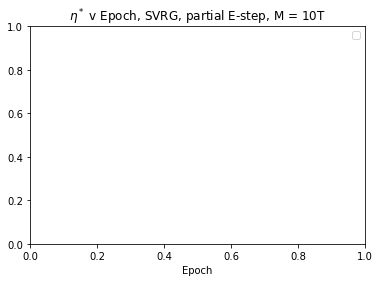

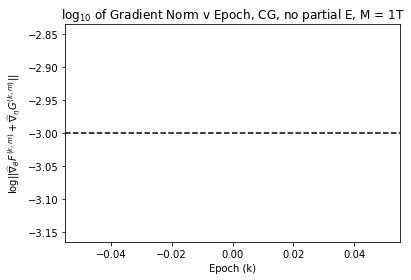

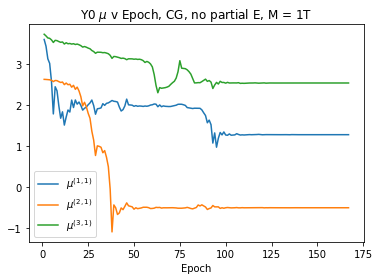

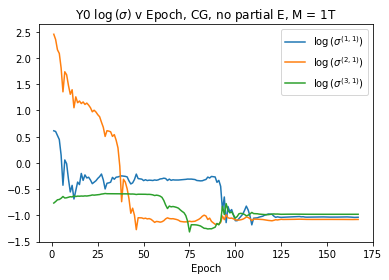

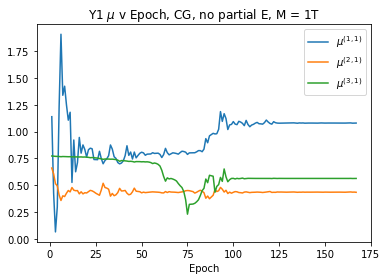

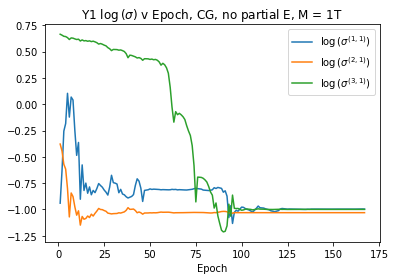

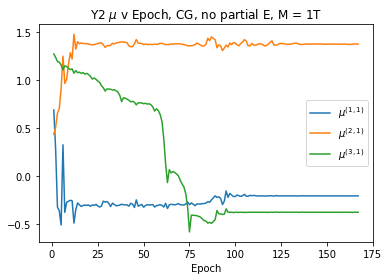

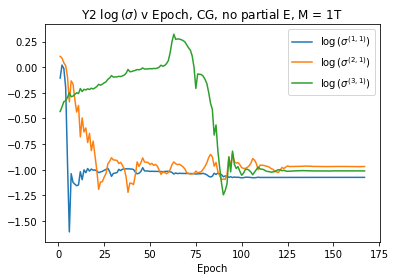

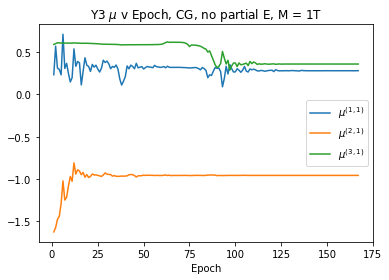

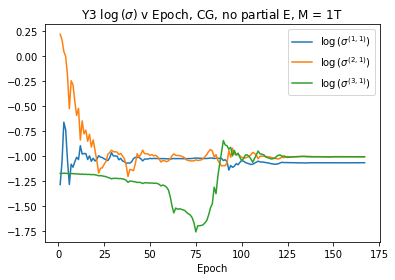

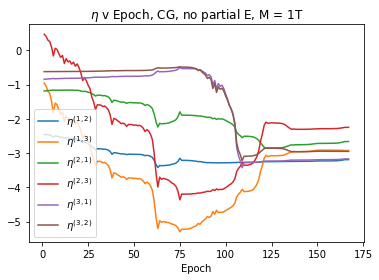

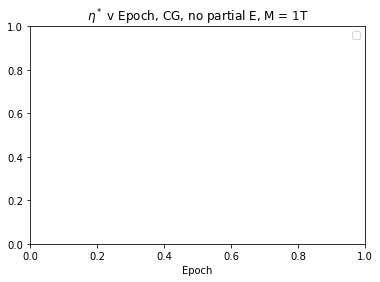

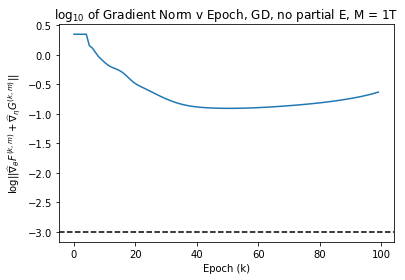

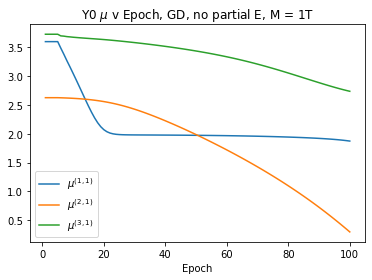

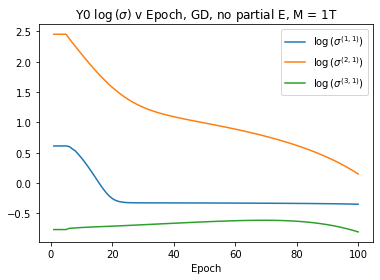

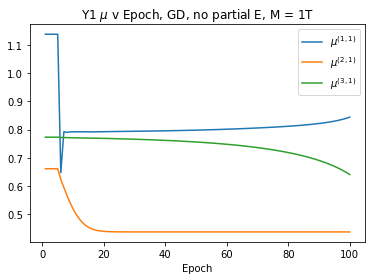

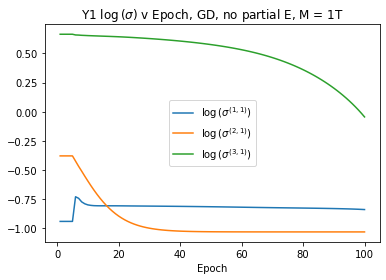

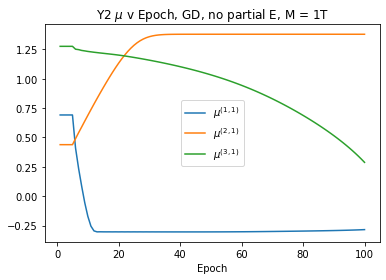

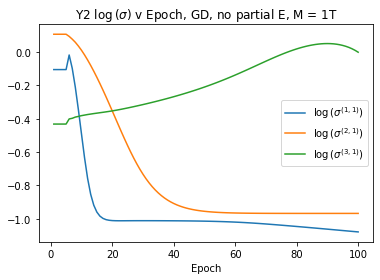

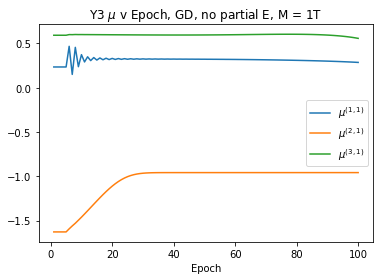

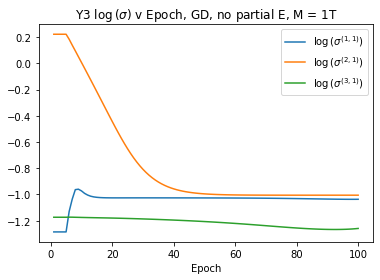

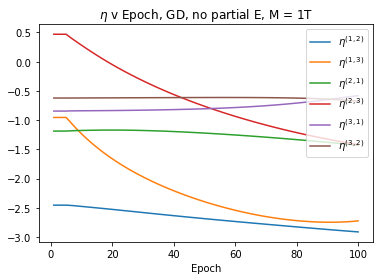

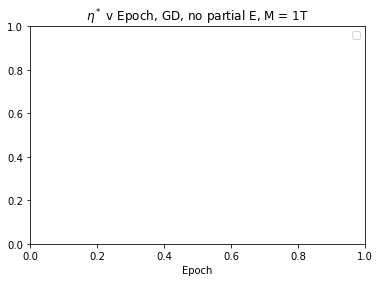

In [9]:
for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],ll_star,method,PE,M,optims["control"].features[1],T,K,d)

In [29]:
display(optims[method_star].eta_trace[1])

[array([[ 0.        , -0.04104855, -0.14974445, -0.68153845, -0.51455389],
        [-0.6298834 ,  0.        , -1.20091954, -0.53539455, -1.79889616],
        [-3.53285839, -0.47144173,  0.        , -1.64007429,  0.65952809],
        [-2.43369303, -1.1694875 , -1.13880217,  0.        ,  0.1014636 ],
        [-1.80541663, -2.17279241, -2.39805625, -2.96556544,  0.        ]]),
 [array([[0.]]), array([[0.]]), array([[0.]]), array([[0.]]), array([[0.]])]]

In [31]:
display(optims[method_star].eta0_trace[1])

[array([ 0.        , -1.04869783, -1.41348288, -1.70532364,  1.93126396]),
 [array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]]

In [32]:
display(optims[method_star].theta_trace[1])
display(optims[method_star].theta_trace[-1])

[{},
 [{'Y0': {'mu': array([1.1491484]), 'log_sig': array([-0.56610564])}},
  {'Y0': {'mu': array([1.18010873]), 'log_sig': array([1.16942988])}},
  {'Y0': {'mu': array([1.48536701]), 'log_sig': array([-1.23494082])}},
  {'Y0': {'mu': array([0.92590664]), 'log_sig': array([-0.86533968])}},
  {'Y0': {'mu': array([-0.21531898]), 'log_sig': array([-0.78066977])}}]]

[{},
 [{'Y0': {'mu': array([1.7812267]), 'log_sig': array([-1.52921498])}},
  {'Y0': {'mu': array([1.02230444]), 'log_sig': array([-1.39144404])}},
  {'Y0': {'mu': array([1.41310739]), 'log_sig': array([-1.77642312])}},
  {'Y0': {'mu': array([0.44789387]), 'log_sig': array([-1.00735363])}},
  {'Y0': {'mu': array([-0.27671856]), 'log_sig': array([-0.96365766])}}]]

# Check gradient accuracy

In [10]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "mu"

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_theta[1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

AttributeError: 'str' object has no attribute 'items'

In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "log_sig"
t = 0

k = k0*optims[key].K[1] + k1

optims[key].E_step()

delta = 1e-10

ll_0 = optims[key].get_log_f(t)[0][k]
#print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_f(t)[0][k]
#print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].get_log_f(t)[1][1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 8

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[0][0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

k0 = 0

i = 1

t = 15

optims[key].E_step()

delta = 1e-4

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta0[1][k0][i] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta0[1][k0][i] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[1][1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 1

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)

print(fd_grad)
print(grad)

#optims["control"].theta